# Classification with Deep Neural Networks

## Load MNIST Dataset

In [20]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [21]:
from torchvision import datasets, transforms

In [22]:
train = datasets.MNIST(
    '../data', train=True, download=True, 
    # train dataset 이면 train=True, 아니면 train=False
    # mnist 없을 경우, 자동 다운로드 
    transform=transforms.Compose([
        transforms.ToTensor(), # tensor 형태로 가져옴 
    ]),
)
test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

In [23]:
train.data.size()

torch.Size([60000, 28, 28])

In [24]:
train.targets.size() # label 

torch.Size([60000])

In [25]:
test.data.size()

torch.Size([10000, 28, 28])

In [26]:
test.targets.size()

torch.Size([10000])

In [27]:
def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28,28)

    plt.imshow(img, cmap='gray')
    plt.show()

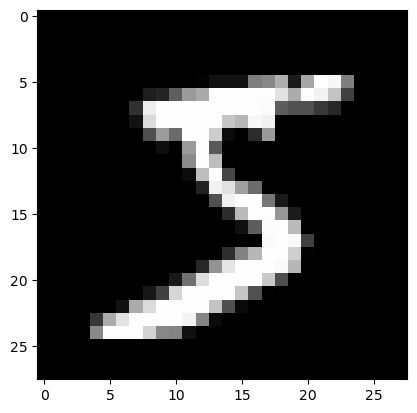

In [28]:
plot(train.data[0])

In [29]:
x = train.data.float() / 255.  # 정규화 
y = train.targets

print(x.size())
print(y.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


In [30]:
print(x.size(0)) 
# batch size (60,000개 샘플)

60000


In [31]:
x = x.view(x.size(0), -1) # (60000,28*28) 
# 각 이미지를 1차원 벡터로 평탄화 
print(x.shape, y.shape)

torch.Size([60000, 784]) torch.Size([60000])


In [32]:
x.size(-1)

784

In [33]:
max(y)
# y(label) 중 가장 큰 값 [0~9]

tensor(9)

In [34]:
input_size = x.size(-1)
output_size = int(max(y)) + 1 # 10개 

print('input_size: %d, output_size: %d' % (input_size, output_size))

input_size: 784, output_size: 10


In [35]:
# Train / Valid ratio (8:2)
ratios = [.8, .2]

# 전체 데이터셋 크기의 80%를 학습 데이터로, 20%를 검증 데이터로 사용
train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])

# 테스트 데이터의 크기를 설정
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

Train 48000 / Valid 12000 / Test 10000 samples.


In [37]:
(test.data.float() / 255.)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [36]:
(test.data.float() / 255.).view(test_cnt, -1)
# 28*28 이미지 >> 784 (28*28) 1차원 벡터로 변환 
# -1 : 자동으로 계산된 차원
# >> (test_cnt, -1) : (test data samples, 784) 

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [38]:
# 데이터를 무작위로 섞기 위해 인덱스를 랜덤하게 생성
# indices는 데이터셋 크기만큼의 랜덤 인덱스를 생성
indices = torch.randperm(x.size(0))

# 무작위로 섞인 인덱스를 사용하여 데이터를 섞음
# index_select 사용, 데이터셋 x와 레이블 y를 랜덤하게 섞기
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

# 데이터를 학습과 검증 세트로 나누기 
x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

# 테스트 데이터를 추가
# 테스트 데이터는 0-255 범위의 값을 0-1로 스케일링
# view 함수 사용 테스트 데이터 형상 맞추기(평탄화)
x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [test.targets]

# 각 데이터셋 (학습, 검증, 테스트)의 크기를 출력
for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


## Build Model & Optimizer

In [39]:
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1), 
    #log softmax 사용, 맨 마지막 dim을 softmax 적용(10) 
)

model

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=300, out_features=200, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=200, out_features=100, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=50, out_features=10, bias=True)
  (13): LogSoftmax(dim=-1)
)

In [40]:
crit = nn.NLLLoss()

In [41]:
optimizer = optim.Adam(model.parameters())

## Move to GPU if it is available

In [42]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [43]:
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

## Train

In [44]:
n_epochs = 1000
batch_size = 256
print_interval = 10

In [45]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [46]:
train_history, valid_history = [], []

# 지정된 에폭 수만큼 학습을 반복
for i in range(n_epochs):
    # 학습 데이터셋의 인덱스를 무작위로 섞기 
    indices = torch.randperm(x[0].size(0)).to(device)
     # 무작위로 섞인 인덱스를 사용하여 학습 데이터를 재배열
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    # x[0] : 학습데이터, y[0]: 레이블 
    
    # 데이터를 배치 단위로 나누기 
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    # 각 배치에 대해 학습 수행 
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        # 손실(loss) 계산 (예측값-실제값)
        loss = crit(y_hat_i, y_i.squeeze())
        
        # 기울기 초기화 
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        # 현재 배치 손실 누적         
        train_loss += float(loss) 
        # This is very important to prevent memory leak.
        # 메모리 누수 방지위해 float로 변환 

    # 학습 손실을 배치 수로 나누어 평균 손실 구하기 
    train_loss = train_loss / len(x_)
    
    # 평가 단계 (기울기 gradient 계산하지 않음)    
    with torch.no_grad():
        # 검증 데이터를 배치 단위로 나누기 
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        # 각 배치에 대해 검증 수행 
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    # 학습 및 검증 손실 기록 
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
    
    # 현재 에폭의 검증 손실이 가장 낮은 손실보다 낮으면 갱신    
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        # 모델의 현재 상태 복사 >> 저장 
        best_model = deepcopy(model.state_dict())
    else:
        # 개선이 없고 조기 종료 조건 만족시, 학습 종료 
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

# 최적의 검증 손실과 해당 에폭 출력 
print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
# 가장 좋은 성능 보인 모델 상태 로드 
model.load_state_dict(best_model)

Epoch 10: train loss=2.3205e-02  valid_loss=9.5918e-02  lowest_loss=8.7004e-02
Epoch 20: train loss=1.2981e-02  valid_loss=1.0535e-01  lowest_loss=8.7004e-02
Epoch 30: train loss=1.0374e-02  valid_loss=1.2458e-01  lowest_loss=8.7004e-02
Epoch 40: train loss=6.3796e-03  valid_loss=1.1208e-01  lowest_loss=8.7004e-02
Epoch 50: train loss=4.1402e-03  valid_loss=1.1097e-01  lowest_loss=8.7004e-02
There is no improvement during last 50 epochs.
The best validation loss from epoch 9: 8.7004e-02


<All keys matched successfully>

## Loss History

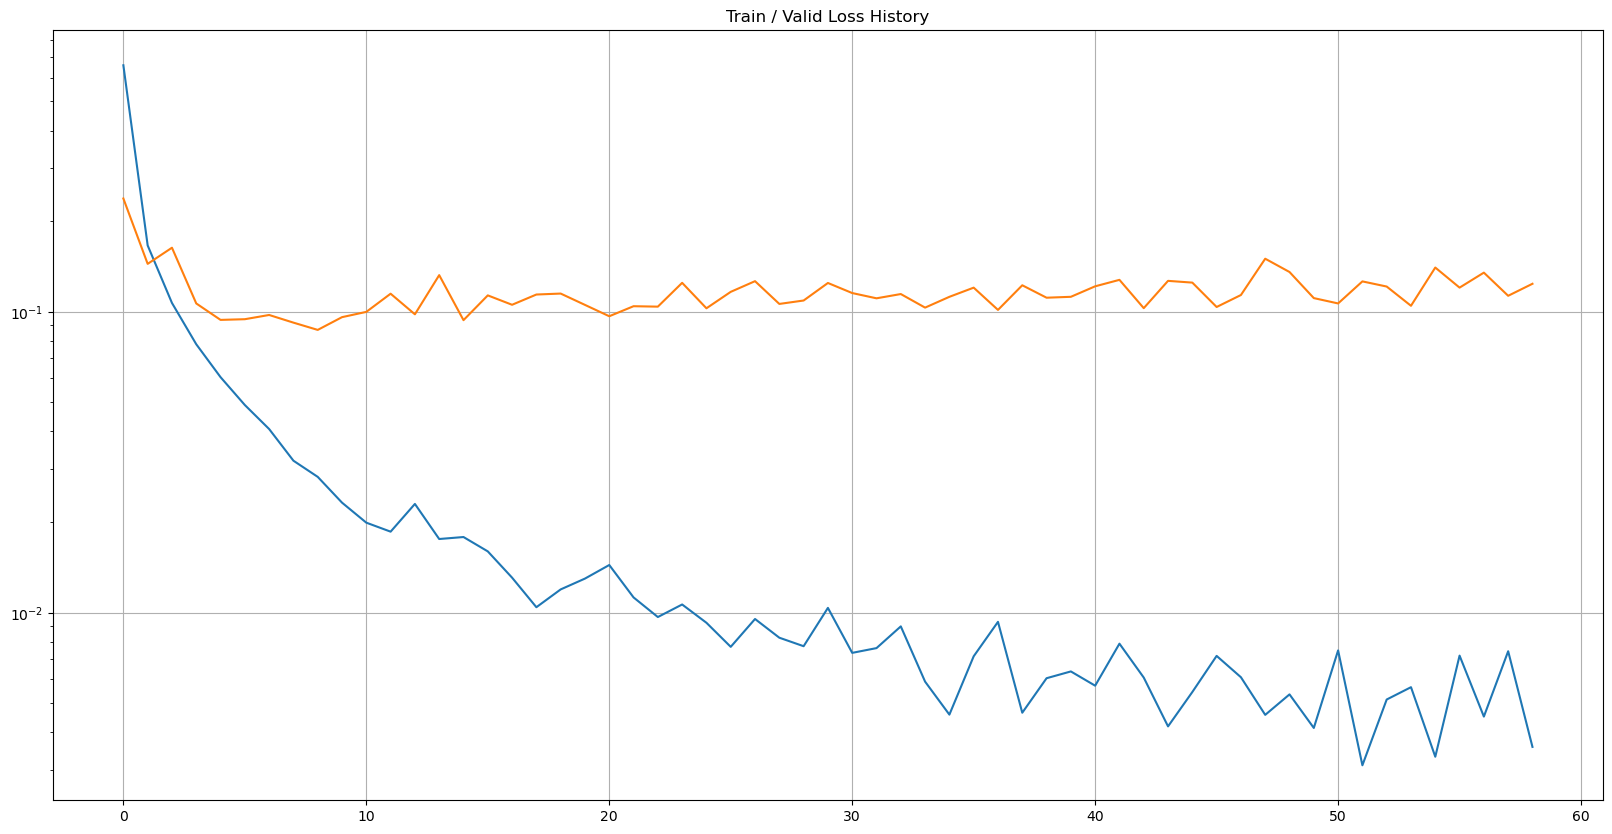

In [47]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

## Let's see the result!

In [53]:
test_loss = 0
y_hat = []

# 평가 모드 전환 >> 기울기 계산 비활성화 
with torch.no_grad():
    # 테스트 데이터 배치 단위로 나누기 
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)

    # 각 배치에 대해 테스트 수행 
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        
        print(y_hat_i)
        print(y_hat_i.size())
        print()
        print(y_i)
        print(y_i.size())
        print()
        print(y_i.squeeze())
        print(y_i.squeeze().size())
        print()
        
        loss = crit(y_hat_i, y_i.squeeze())
        # squeeze() (batch_size, 1)일 경우 (batch_size,)로 변환 

        # 테스트 손실을 누적
        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)
# 배치별 예측값을 하나의 텐서로 결합

print("Validation loss: %.4e" % test_loss)

tensor([[-2.0723e+01, -1.7328e+01, -1.1954e+01,  ..., -9.5367e-06,
         -1.6716e+01, -1.2911e+01],
        [-1.6914e+01, -1.7670e+01, -6.0797e-06,  ..., -1.7261e+01,
         -1.5525e+01, -2.6479e+01],
        [-1.5926e+01, -7.6265e-04, -9.1655e+00,  ..., -7.7579e+00,
         -9.3640e+00, -1.3390e+01],
        ...,
        [-1.8807e+01, -2.6344e+01, -2.6375e+01,  ..., -1.9804e+01,
         -1.5977e+01, -1.3501e+01],
        [-1.9016e+01, -1.6384e+01, -1.1011e+01,  ..., -3.8146e-05,
         -1.5576e+01, -1.0905e+01],
        [-1.4093e+01, -1.1305e+01, -6.7126e+00,  ..., -1.4915e-03,
         -1.1155e+01, -9.2335e+00]])
torch.Size([256, 10])

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0,

In [67]:
print(y[-1])
# 테스트 데이터셋의 실제 레이블을 포함하는 텐서

tensor([7, 2, 1,  ..., 4, 5, 6])


In [74]:
y[-1].size()

torch.Size([10000])

In [70]:
y_hat.size()

torch.Size([10000, 10])

In [72]:
y_hat.size(-1)

10

In [68]:
torch.argmax(y_hat, dim=-1)
# 예측값 y_hat에서 각 샘플에 대한 가장 높은 확률을 가진 클래스 인덱스를 반환. 
# >> 모델이 예측한 클래스 레이블

tensor([7, 2, 1,  ..., 4, 5, 6])

In [73]:
torch.argmax(y_hat, dim=-1).size()

torch.Size([10000])

In [54]:
# 맞춘 샘플의 수를 세기 위해, 예측값의 argmax와 실제값을 비교
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
# 전체 샘플 수를 float형으로 변환하여 저장
total_cnt = float(y[-1].size(0))

print('Accuracy: %.4f' % (correct_cnt / total_cnt))

Accuracy: 0.9777


In [55]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [56]:
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
             index=['true_%d' % i for i in range(10)],
             columns=['pred_%d' % i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,971,0,1,1,0,1,4,0,1,1
true_1,0,1123,3,0,0,0,2,2,5,0
true_2,4,0,1014,5,1,1,1,4,2,0
true_3,0,0,4,989,0,1,0,4,2,10
true_4,0,1,4,1,950,0,4,5,2,15
true_5,1,0,0,13,1,869,2,1,3,2
true_6,5,3,2,1,5,6,930,0,6,0
true_7,2,1,7,2,0,0,0,1010,1,5
true_8,3,0,14,3,3,5,0,5,938,3
true_9,5,2,1,6,4,2,0,2,4,983


squeeze 예제

In [61]:
import torch

# 예측값 예제 (batch_size, num_classes)
y_hat_i = torch.tensor([[0.2, 0.8], [0.6, 0.4], [0.4, 0.6]])
print(y_hat_i.shape) # torch.Size([3,2])
# 실제값 예제 (batch_size, 1)
y_i = torch.tensor([[1], [0], [1]])

# squeeze() 사용 전
print(y_i.shape)  # torch.Size([3, 1])

# squeeze() 사용 후
y_i_squeezed = y_i.squeeze()
print(y_i_squeezed.shape)  # torch.Size([3])


torch.Size([3, 2])
torch.Size([3, 1])
torch.Size([3])


In [59]:
import torch.nn as nn

crit = nn.CrossEntropyLoss()
loss = crit(y_hat_i, y_i.squeeze())
loss
# y_hat_i : 모델값의 예측값 텐서 (batch_size,num_classes)
# y_i.squeeze() : (batch_size,1) >> (batch_size,)

# 예측값의 크기 (batch_size, num_classes)와 실제값의 크기 (batch_size,)가 손실 함수에 입력으로 사용될 수 있음 
# >> 이는 CrossEntropyLoss 함수가 예측값을 소프트맥스 함수에 통과시키고, 실제 클래스 레이블과 비교하여 손실을 계산하는 방식 때문

tensor(0.5446)

In [66]:
import torch
import torch.nn as nn

# 배치 크기와 클래스 수를 정의합니다.
batch_size = 3
num_classes = 5

# 예측값 텐서 (배치 크기, 클래스 수)
# >> 각 샘플에 대해 5개의 클래스에 대한 로짓 값을 포함
y_hat_i = torch.tensor([[2.0, 1.0, 0.1, 0.0, 0.0],
                        [1.0, 3.0, 0.1, 0.0, 0.0],
                        [0.0, 0.0, 0.1, 2.0, 1.0]])


# 실제값 텐서 (배치 크기)
y_i = torch.tensor([0, 1, 3]) # 정수형 클래스 레이블 
print(y_i)  
print(y_i.squeeze())
print(y_i.size()) # (batch_size, ) >> torch.Size([3])


# 손실 함수 정의
crit = nn.CrossEntropyLoss()

# 손실 계산
loss = crit(y_hat_i, y_i)
print(loss)


tensor([0, 1, 3])
tensor([0, 1, 3])
torch.Size([3])
tensor(0.4723)


argmax() 예제

In [81]:
y = torch.tensor([[1], [0], [2], [1]])

y_hat = torch.tensor([[0.1, 0.7, 0.2], 
                      [0.8, 0.1, 0.1], 
                      [0.2, 0.2, 0.6], 
                      [0.4, 0.4, 0.2]])

print(y.size())
print(y_hat.size())

torch.Size([4, 1])
torch.Size([4, 3])


In [82]:
# 맞춘 샘플 수 계산 
correct_cnt = (y.squeeze() == torch.argmax(y_hat, dim=-1)).sum()
correct_cnt

tensor(3)

In [84]:
y_squeezed = y.squeeze()
print(y_squeezed) 
print(y_squeezed.size()) # (4, )

tensor([1, 0, 2, 1])
torch.Size([4])


In [86]:
y_hat

tensor([[0.1000, 0.7000, 0.2000],
        [0.8000, 0.1000, 0.1000],
        [0.2000, 0.2000, 0.6000],
        [0.4000, 0.4000, 0.2000]])

In [87]:
torch.argmax(y_hat, dim=-1)

tensor([1, 0, 2, 0])

In [88]:
y_pred = torch.argmax(y_hat, dim=-1)

In [90]:
correct_tensor = (y_squeezed == y_pred)
correct_tensor

tensor([ True,  True,  True, False])

In [91]:
correct_cnt = (y_squeezed == y_pred).sum()
correct_cnt # 맞춘 개수 3

tensor(3)

In [93]:
y.size()

torch.Size([4, 1])

In [94]:
y.size(0)

4

In [97]:
total_cnt = float(y.size(0))
total_cnt

4.0

In [98]:
# 정확도 계산
print('Accuracy: %.4f' % (correct_cnt / total_cnt))


Accuracy: 0.7500
